In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import neurospyke as ns
import h5py
from scipy.io import loadmat
from scipy.signal import savgol_filter, butter, lfilter
import os
import shutil
import preprocessing
import json
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
f = open('settings.json')
settings = json.load(f)
f.close()

resampling_frequency = settings['resampling_frequency']
resampling_time = 1 / resampling_frequency

group = settings['group']
subject = settings['subject']
conditions = settings['conditions']
areas = list(settings['areas'].keys())
n_channels = settings['n_channels']
n_stimuli = settings['n_stimuli']
n_components = 3
trial_duration = 0.5
trial_samples = trial_duration * resampling_frequency
trial_range = np.arange(trial_samples).astype(np.int_)

data = loadmat(os.path.join('./output', group, subject, subject + '.mat'))
IFR = data['data']

In [101]:
NPD = np.ndarray([np.size(conditions), np.size(areas), n_components, np.size(IFR, axis=3), np.size(IFR, axis=4)])

In [102]:
for condition_idx in np.arange(np.size(conditions)):
    for area_idx in np.arange(np.size(areas)):
        IFR_trials = IFR[condition_idx, area_idx]
        IFR_mean_trials = np.mean(IFR_trials, axis=1)

        my_pca = PCA(n_components)
        my_pca.fit(np.transpose(IFR_mean_trials))

        for trial_idx in np.arange(n_stimuli):
            NPD[condition_idx, area_idx, :, trial_idx, :] = np.transpose(
                my_pca.transform(
                    np.transpose(IFR_trials[:, trial_idx, :])
                )
            )

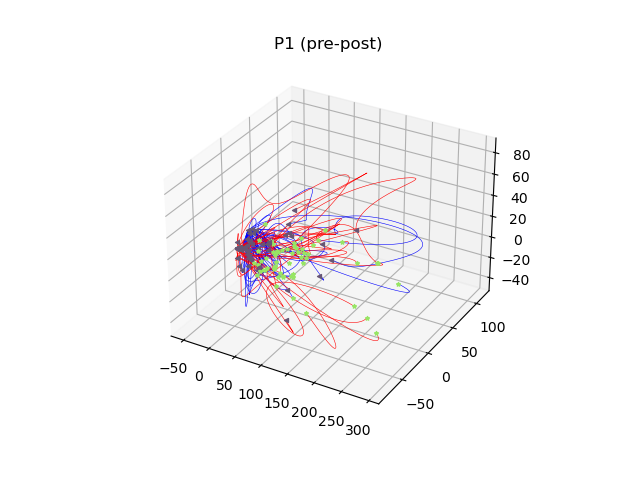

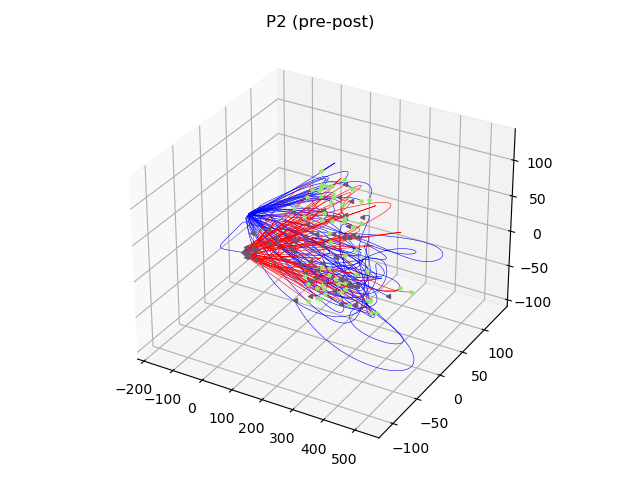

In [103]:
fig1 = ns.visualization.pyplot.figure()
fig2 = ns.visualization.pyplot.figure()
ax_P1 = fig1.add_subplot(111, projection='3d')
ax_P2 = fig2.add_subplot(111, projection='3d')
axs_titles = ['P1 (pre-post)', 'P2 (pre-post)']
axs = [ax_P1, ax_P2]
colors = ['#0000FF', '#FF0000']

for condition_idx in np.arange(np.size(conditions)):
    color = colors[condition_idx]
    for area_idx in np.arange(np.size(areas)):
        ax = axs[area_idx]
        for trial_idx in np.arange(n_stimuli):
            ax.plot(
                NPD[condition_idx, area_idx, 0, trial_idx, trial_range],
                NPD[condition_idx, area_idx, 1, trial_idx, trial_range],
                NPD[condition_idx, area_idx, 2, trial_idx, trial_range],
                color=color,
                linewidth=0.4
            )
            ax.scatter(
                NPD[condition_idx, area_idx, 0, trial_idx, trial_range[0]], 
                NPD[condition_idx, area_idx, 1, trial_idx, trial_range[0]], 
                NPD[condition_idx, area_idx, 2, trial_idx, trial_range[0]],
                color='#97e564',
                s=8,
                marker='*',

            )
            ax.scatter(
                NPD[condition_idx, area_idx, 0, trial_idx, trial_range[-1]], 
                NPD[condition_idx, area_idx, 1, trial_idx, trial_range[-1]], 
                NPD[condition_idx, area_idx, 2, trial_idx, trial_range[-1]],
                color='#675674',
                s=8,
                marker='<'
            )
            ax.set_title(axs_titles[area_idx])

ns.visualization.pyplot.tight_layout()
